In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

**Задание **

Провести исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [2]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Посмотрим, сколько посетителей заходио на сайт (количество строк в нашем датафрейме)

In [3]:
#количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [4]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Из сообщений следует, что пропущенных значений нет.

In [7]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0   
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted            ...            \
                50%        75%       max     count      mean  ...  75%  max   
group                                                         ...             
control    788053.5  867155.50  945998.0  147202.0  0.120399  ...  0.0  1.0   
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  ...  0.0  1.0   

            revenue                                                         
              count        mean         std  min  25%    50%    75%    max  
group                                                                       
control    147202.0   87.431896  102.424926  0.0  0.0    0.0  250.0  250.0  
treatment  147276.0  116.496238  102.732069  0.0  0.0  100.0  250.0  250.0  

[2 rows x 24 columns]

Из статистик видно, что среднее значение, разное. Говорить, что это средний чек - преждевременно, т.к. это просто среднее значение среди всех покупателей, включая тех, кто ничего не купил.

Попробуем посчитать средний чек обычными статистическими методами. Оставим только те значения, где пользователи покупали товары.

In [8]:
df_shopped = df[df['revenue']>0]
df_shopped['revenue'].unique()

array([100, 250])

In [9]:
df_shopped.groupby('group').describe()

user_id                                                             \
             count           mean           std       min       25%       50%   
group                                                                           
control    73401.0  788252.649882  91368.966484  630002.0  709370.0  788250.0   
treatment  98077.0  787805.305780  91103.324747  630000.0  708734.0  787992.0   

                              converted            ...            revenue  \
                75%       max     count      mean  ...  75%  max    count   
group                                              ...                      
control    867400.0  945994.0   73401.0  0.120175  ...  0.0  1.0  73401.0   
treatment  866615.0  945999.0   98077.0  0.119263  ...  0.0  1.0  98077.0   

                                                                     
                 mean        std    min    25%    50%    75%    max  
group                                                                
control    175.340254  74.999739  100.0  100.0  250.0  250.0  250.0  
treatment  174.935000  75.000354  100.0  100.0  100.0  250.0  250.0  

[2 rows x 24 columns]

Теперь картина не такая и однозначная. И видим, что хоть и на чуть чуть, но все же средний чек на контрольной группе немного выше. Однако, в тестовой группе впринципе совершили больше транзакций.

Тут опять же, если цель была повысить доход, то в тестовой группе он выше, чем в контрольной. Причем разница в доходе несоизмерима с разницей среднего чего. Посмотрим для верности еще и общий доход по группам

In [10]:
df_shopped.groupby(['group']).sum()

,user_id,converted,revenue
group,,,
control,57858532754,8821,12870150
treatment,77265580975,11697,17157100


Видим, что и доход стал выше за счет большего охвата

**Задание **

А теперь ответьте на главный вопрос данного этапа:  выявил ли предварительный анализ, что дизайн кнопки влияет на конверсию и если да, то как именно?

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Конверсия сайта со старым дизайном не меньше, чем с новым"

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения, т.е. доли, кликнувших посетителей в контрольной и тестовой выборках.

#### Проведение вычислений. $T$-test.

In [27]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df_shopped.query("group == 'treatment'")['revenue'],
                                                              df_shopped.query("group == 'control'")['revenue'],
                                                              alternative="larger",
                                                              usevar='unequal')

In [28]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=-1.1071248128460085,  p_value=0.8658791733007705


#### Проведение вычислений. $Mann–Whitney$-test.

In [29]:
w_score, p_value = scipy.stats.mannwhitneyu(df_shopped.query("group == 'treatment'")['revenue'], 
                         df_shopped.query("group == 'control'")['revenue'],
                         alternative="greater")

In [30]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=3589750257.0,  p_value=0.8658795878681167


Мы видим, что вероятность очень велика и мы не можем откинуть нулевую теорию. Значит принимаем во снимание, что средний чек не вырос.

## bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [16]:
df_shopped.head()

,user_id,timestamp,group,landing_page,converted,revenue
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,250
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,100
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,100


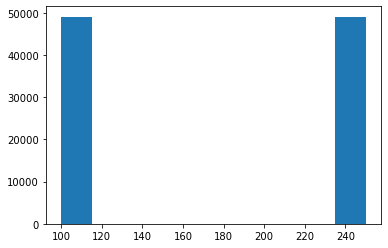

In [17]:
plt.hist(df_shopped.loc[df['group']=='treatment', 'revenue']);

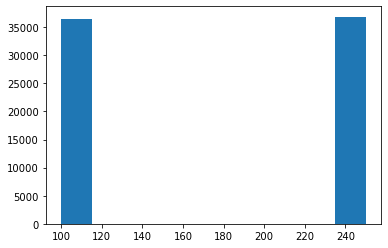

In [18]:
plt.hist(df_shopped.loc[df['group']=='control', 'revenue']);

In [19]:
b = df_shopped.loc[df['group']=='treatment', 'revenue'].values
a = df_shopped.loc[df['group']=='control', 'revenue'].values

In [20]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

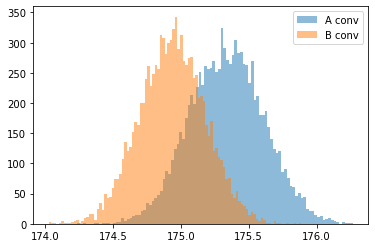

In [21]:
plt.hist(a_means, label='A revenue', alpha=0.5, bins=100)
plt.hist(b_means, label='B revenue', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [22]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(174.8130134466833, 175.87771283769976)

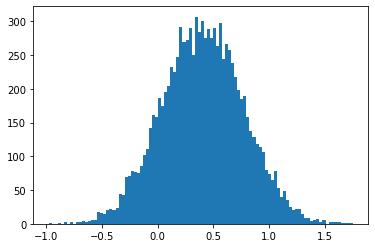

In [23]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [24]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.8629

При бутстрапировании мы снова видим подтверждение, статистических данных, а так же результатов, полученных при вычислениях критерия Манна-Уитни. Таким образом получается, что средний чек у контрольной группы и наша альтернативная гипотеза неверна.